Brennan Duff

Variational Autoencoders on the SVHN Dataset

1: Load and preprocess the SVHN dataset

In [ ]:
import numpy as np
from scipy.io import loadmat
import tensorflow as tf
from tensorflow.keras import layers, models, losses
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import os

# Load and preprocess the SVHN dataset
def load_svhn_data():
    # Download the dataset if it doesn't exist
    !wget -nc http://ufldl.stanford.edu/housenumbers/train_32x32.mat
    !wget -nc http://ufldl.stanford.edu/housenumbers/test_32x32.mat

    # Load data
    train_data = loadmat('train_32x32.mat')
    test_data = loadmat('test_32x32.mat')

    # Preprocess the data
    x_train = np.transpose(train_data['X'], (3, 0, 1, 2)).astype('float32') / 255.0
    y_train = train_data['y'].flatten()
    x_test = np.transpose(test_data['X'], (3, 0, 1, 2)).astype('float32') / 255.0
    y_test = test_data['y'].flatten()

    return x_train, y_train, x_test, y_test

2: Define the VAE components

3: Train the VAE with different latent dimensions

In [ ]:

# Define the VAE components

# Create the encoder
def build_encoder(latent_dim):
    encoder_input = layers.Input(shape=(32, 32, 3), name="encoder_input")
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(encoder_input)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Flatten and add the dense layers
    x = layers.Flatten()(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])

    return models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")

# Create the decoder
def build_decoder(latent_dim):
    decoder_input = layers.Input(shape=(latent_dim,), name="decoder_input")
    x = layers.Dense(4 * 4 * 128, activation="relu")(decoder_input)
    x = layers.Reshape((4, 4, 128))(x)
    x = layers.Conv2DTranspose(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2DTranspose(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2DTranspose(32, (3, 3), activation="relu", padding="same")(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoder_output = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

    return models.Model(decoder_input, decoder_output, name="decoder")

# Custom layer for sampling from latent space
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Build the VAE
def build_vae(latent_dim):
    encoder = build_encoder(latent_dim)
    decoder = build_decoder(latent_dim)
    vae_input = layers.Input(shape=(32, 32, 3))
    z_mean, z_log_var, z = encoder(vae_input)
    reconstruction = decoder(z)

    vae = models.Model(vae_input, reconstruction, name="vae")
    return vae

# Load dataset
x_train, y_train, x_test, y_test = load_svhn_data()

# Training loop with model saving/loading
latent_dims = [2, 5, 10]
for dim in latent_dims:
    print(f'Training VAE with latent dimension: {dim}')

    # Build and compile the model
    vae = build_vae(latent_dim=dim)
    vae.compile(optimizer='adam', loss=losses.binary_crossentropy)

    # Setup callbacks for saving the model and early stopping
    checkpoint_path = f'vae_model_latent_{dim}.h5'
    checkpoint_callback = ModelCheckpoint(
        checkpoint_path,
        save_best_only=True,
        monitor='val_loss',
        mode='min',
        verbose=1
    )

    early_stopping_callback = EarlyStopping(
        monitor='val_loss',
        patience=5,
        verbose=1
    )

    # Check if a model exists for this latent dimension
    if os.path.exists(checkpoint_path):
        vae.load_weights(checkpoint_path)
        initial_epoch = 10  # Set to the last epoch you trained
        print(f'Loaded existing model for latent dimension {dim}. Resuming from epoch {initial_epoch}.')
    else:
        initial_epoch = 0
        print(f'No existing model found for latent dimension {dim}, starting fresh.')

    # Train the VAE
    history = vae.fit(
        x_train,
        x_train,
        initial_epoch=initial_epoch,
        epochs=initial_epoch + 15,  # Adjust based on your observation
        batch_size=64,  # Choose appropriate batch size
        validation_data=(x_test, x_test),
        callbacks=[checkpoint_callback, early_stopping_callback]
    )



--2024-10-10 22:09:01--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  1.62MB/s    in 2m 9s   

2024-10-10 22:11:11 (1.34 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2024-10-10 22:11:11--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  1.85MB/s    in 46s     

2024-10-10 22:11:57 (1.32 MB/s) - ‘test_32x32.mat’ saved [64275384/64

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1145/1145 [==============================] - ETA: 0s - loss: 0.6343
Epoch 2: val_loss improved from 0.61379 to 0.61346, saving model to vae_model_latent_2.h5
1145/1145 [==============================] - 55s 48ms/step - loss: 0.6343 - val_loss: 0.6135
Epoch 3/15
1145/1145 [==============================] - ETA: 0s - loss: 0.6340
Epoch 3: val_loss improved from 0.61346 to 0.61260, saving model to vae_model_latent_2.h5
1145/1145 [==============================] - 56s 49ms/step - loss: 0.6340 - val_loss: 0.6126
Epoch 4/15
1144/1145 [============================>.] - ETA: 0s - loss: 0.6337
Epoch 4: val_loss did not improve from 0.61260
1145/1145 [==============================] - 57s 50ms/step - loss: 0.6337 - val_loss: 0.6126
Epoch 5/15
1145/1145 [==============================] - ETA: 0s - loss: 0.6335
Epoch 5: val_loss did not improve from 0.61260
1145/1145 [==============================] - 57s 50ms/step - loss: 0.6335 - val_loss: 0.6131
Epoch 6/15
1145/1145 [===========================

4: Visualize the results

814/814 [==============================] - 9s 11ms/step


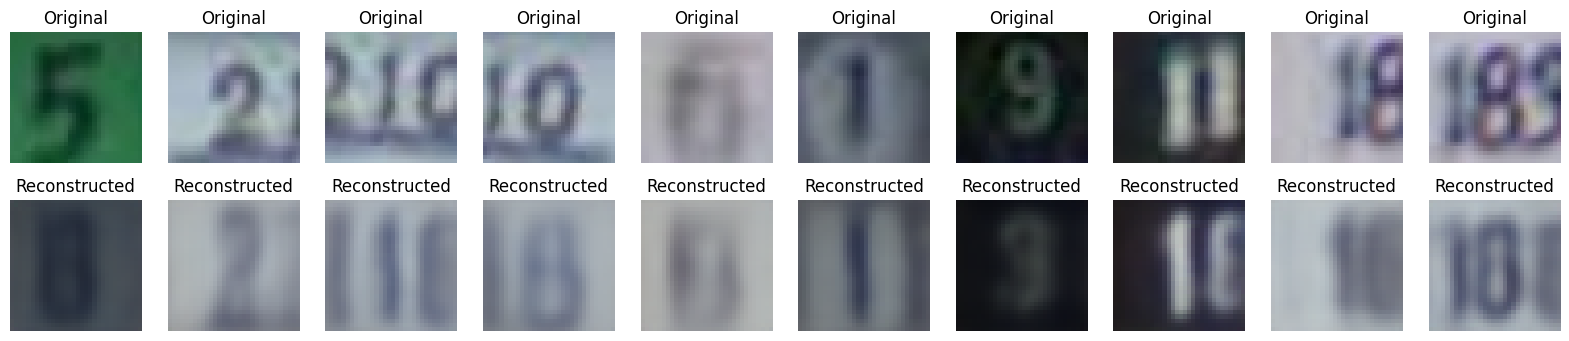

In [ ]:
# Visualize the results
def plot_reconstructed_images(model, x_test, n=10):
    reconstructed_images = model.predict(x_test)

    plt.figure(figsize=(20, 4))

    # Display original images
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i])
        plt.title("Original")
        plt.axis("off")

    # Display reconstructed images
    for i in range(n):
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed_images[i])
        plt.title("Reconstructed")
        plt.axis("off")

# Visualize results for the largest latent dimension
largest_latent_dim = max(latent_dims)
vae = build_vae(largest_latent_dim)
vae.load_weights(f'vae_model_latent_{largest_latent_dim}.h5')  # Load the best model

plot_reconstructed_images(vae, x_test, n=10)
plt.show()

# Visualize the latent space representation if applicable
if largest_latent_dim == 2:
    z_mean, _, _ = build_encoder(largest_latent_dim)(x_test)
    plt.figure(figsize=(8, 8))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test, alpha=0.5, cmap='rainbow')
    plt.colorbar()
    plt.title('Latent Space Representation')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.show()


Clarity: The reconstructed images do not look clear, due to the shortfall of training, each latent dimension only recieved 15 epochs with a batch size of 64.

Distortion: The level of distortion is much less than I would have expected from the amount of epochs, there are some that are very close to the original image (relatively)

Variability: Overall, the quality of the reconstructed set varies around clear-ish. There is an outlier, the first image, which varys greatly in terms of clarity and distortion compared to the rest of the reconstructed set.

Generalization: The amount of training this model has recieved relative to the reconstructed images is impressive. I was expecting much less clarity from the reconstructed set. However, the performance overall was strictly bad. The model does not have a complete understanding of the dataset.